In [1]:
import torch
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from collections import defaultdict

In [2]:
%pwd

'/Users/umbertocarlochiapasco/Desktop/Tesi_Magistrale/scaling_data'

In [149]:
# Regex per i filename
pattern = re.compile(
    r"scalingData_([\d\-]+)_(\d+\.?\d*)_(\d+\.?\d*)_(\d+)_(\d+)_(\d+)\.txt"
)

# Caricamento dei dati
curve_data = []

for filename in glob.glob("scalingData_*.txt"):
    m = pattern.search(filename)
    if not m:
        print(f"Filename non riconosciuto: {filename}")
        continue
    
    Volume_str, kappa, lam, batchsize, meas, steps = m.groups()
    
    # Lato (primo numero di Volume_str)
    dims = list(map(int, Volume_str.split("-")))
    lato = dims[0]
    
    kappa, lam, batchsize, meas, steps = (
        float(kappa), float(lam),
        int(batchsize), int(meas), int(steps)
    )
    
    with open(filename, "r") as f:
        line = f.readline().strip()
    
    work_part, final_part = line.split(" || ", 1)
    loss, loss_err, DF, DF_err, ESS, ESS_err = map(float, final_part.split())
    
    curve_data.append({
        "L": lato,
        "kappa": kappa,
        "lambda": lam,
        "meas": meas,
        "steps": steps,
        "DF": DF,
        "DF_err": DF_err,
        "loss": loss,
        "loss_err": loss_err,
        "ESS": ESS,
        "ESS_err": ESS_err,
    })

#------------FUNZIONI------------#
def parse_frac(s):
    s = s.strip()
    # se è già una rappresentazione decimale, la usiamo così com'è
    if "." in s:
        return float(s)
    # se è solo cifre (es. "2", "1867"), lo interpretiamo come le cifre dopo la virgola: "1867" -> 0.1867
    if s.isdigit():
        return float(s) / (10**len(s))
    # fallback (tenta comunque una conversione)
    return float(s)

def frac_to_str(x):
    """
    Converte un float in stringa senza lo '0.' iniziale,
    per compatibilità con i filename.
    Esempi:
      0.2     -> "2"
      0.1867  -> "1867"
    """
    s = f"{x:.10f}".rstrip("0").rstrip(".")  # rappresentazione decimale pulita
    if s.startswith("0."):
        return s[2:]  # rimuove "0."
    elif s.startswith("."):
        return s[1:]  # rimuove "." se era tipo ".2"
    return s


def plot_vs_volume(kappa_target, lambda_target):
    # Converto i target nel formato filename
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    cmap = plt.cm.get_cmap("tab10")
    
    # Raggruppo per steps
    steps_vals = sorted(set(e["steps"] for e in subset))
    for i, st in enumerate(steps_vals):
        entries = sorted([e for e in subset if e["steps"] == st], key=lambda e: e["L"])
        Ls = [e["L"] for e in entries]
        
        axs[0].errorbar(Ls, [e["DF"] for e in entries], yerr=[e["DF_err"] for e in entries],
                        marker='o', linestyle='--', color=cmap(i), label=f"steps={st}")
        axs[1].errorbar(Ls, [e["loss"] for e in entries], yerr=[e["loss_err"] for e in entries],
                        marker='s', linestyle='--', color=cmap(i), label=f"steps={st}")
        axs[2].errorbar(Ls, [e["ESS"] for e in entries], yerr=[e["ESS_err"] for e in entries],
                        marker='^', linestyle='--', color=cmap(i), label=f"steps={st}")
    
    axs[0].set_title(f"ΔF vs L (kappa={kappa_target}, λ={lambda_target})")
    axs[1].set_title(f"Loss vs L (kappa={kappa_target}, λ={lambda_target})")
    axs[2].set_title(f"ESS vs L (kappa={kappa_target}, λ={lambda_target})")
    for ax in axs:
        ax.set_xlabel("Lato")
        ax.grid(True)
    axs[0].set_ylabel("ΔF")
    axs[1].set_ylabel("Loss")
    axs[2].set_ylabel("ESS")
    axs[0].legend(title="steps")
    
    plt.tight_layout()
    plt.show()

def plot_vs_volumeV3(kappa_target, lambda_target):
    # Converto i target nel formato filename
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    cmap = plt.cm.get_cmap("tab10")
    steps_vals = sorted(set(e["steps"] for e in subset))
    
    # --- Plot 1: Loss vs L ---
    plt.figure(figsize=(8, 5))
    for i, st in enumerate(steps_vals):
        entries = sorted([e for e in subset if e["steps"] == st], key=lambda e: e["L"])
        if len(entries) < 4:
            continue
        Ls = [e["L"] for e in entries]
        D_kl = [e["loss"]-e["DF"] for e in entries]
        plt.errorbar(Ls, D_kl, yerr=[e["loss_err"] for e in entries],
                     marker='s', linestyle='--', color=cmap(i), label=f"steps={st}")
    plt.title(f"$<W>-\Delta F$ vs L ($k$={kappa_target}, λ={lambda_target})", fontsize = 16)
    plt.xlabel("Lattice Side", fontsize = 15)
    plt.ylabel("$D_{KL}$", fontsize = 16)
    plt.grid(True)
    plt.legend(title="steps")
    plt.tight_layout()
    plt.show()
    
    # --- Plot 2: ESS vs L ---
    plt.figure(figsize=(8, 5))
    for i, st in enumerate(steps_vals):
        entries = sorted([e for e in subset if e["steps"] == st], key=lambda e: e["L"])
        if len(entries) < 4:
            continue
        Ls = [e["L"] for e in entries]
        plt.errorbar(Ls, [e["ESS"] for e in entries], yerr=[e["ESS_err"] for e in entries],
                     marker='^', linestyle='--', color=cmap(i), label=f"steps={st}")
    plt.title(f"ESS vs L ($k$={kappa_target}, λ={lambda_target})", fontsize = 16)
    plt.xlabel("Lattice Side", fontsize = 15)
    plt.ylabel("ESS", fontsize = 15)
    plt.grid(True)
    plt.legend(title="steps")
    plt.tight_layout()
    plt.show()

def plot_vs_steps(kappa_target, lambda_target):
    # Converto i target nel formato filename
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    cmap = plt.cm.get_cmap("tab10")
    
    # Raggruppo per lato
    L_vals = sorted(set(e["L"] for e in subset))
    for i, L in enumerate(L_vals):
        entries = sorted([e for e in subset if e["L"] == L], key=lambda e: e["steps"])
        steps = [e["steps"] for e in entries]
        
        axs[0].errorbar(steps, [e["DF"] for e in entries], yerr=[e["DF_err"] for e in entries],
                        marker='o', linestyle='--', color=cmap(i), label=f"L={L}")
        axs[1].errorbar(steps, [e["loss"] for e in entries], yerr=[e["loss_err"] for e in entries],
                        marker='s', linestyle='--', color=cmap(i), label=f"L={L}")
        axs[2].errorbar(steps, [e["ESS"] for e in entries], yerr=[e["ESS_err"] for e in entries],
                        marker='^', linestyle='--', color=cmap(i), label=f"L={L}")
    
    axs[0].set_title(f"ΔF vs steps (kappa={kappa_target}, λ={lambda_target})")
    axs[1].set_title(f"Loss vs steps (kappa={kappa_target}, λ={lambda_target})")
    axs[2].set_title(f"ESS vs steps (kappa={kappa_target}, λ={lambda_target})")
    for ax in axs:
        ax.set_xlabel("steps")
        ax.grid(True)
    axs[0].set_ylabel("ΔF")
    axs[1].set_ylabel("Loss")
    axs[2].set_ylabel("ESS")
    axs[0].legend(title="Lato")
    
    plt.tight_layout()
    plt.show()

def plot_vs_stepsV2(kappa_target, lambda_target):
    # Converto i target nel formato filename
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    cmap = plt.cm.get_cmap("tab10")
    
    # Raggruppo per lato
    L_vals = sorted(set(e["L"] for e in subset))
    for i, L in enumerate(L_vals):
        entries = sorted([e for e in subset if e["L"] == L], key=lambda e: e["steps"])
        d_KL = [e["loss"]-e["DF"] for e in entries]
        steps = [e["steps"] for e in entries]
        
        axs[0].errorbar(steps, [e["DF"] for e in entries], yerr=[e["DF_err"] for e in entries],
                        marker='o', linestyle='--', color=cmap(i), label=f"L={L}")
        axs[1].errorbar(steps, d_KL, yerr=[e["loss_err"] for e in entries],
                        marker='s', linestyle='--', color=cmap(i), label=f"L={L}")
        axs[2].errorbar(steps, [e["ESS"] for e in entries], yerr=[e["ESS_err"] for e in entries],
                        marker='^', linestyle='--', color=cmap(i), label=f"L={L}")
    
    axs[0].set_title(f"$\Delta F$ vs steps ($k$={kappa_target}, λ={lambda_target})")
    axs[1].set_title(f"$<W>-\Delta F$ vs steps ($k$={kappa_target}, λ={lambda_target})")
    axs[2].set_title(f"ESS vs steps ($k$={kappa_target}, λ={lambda_target})")
    for ax in axs:
        ax.set_xlabel("steps")
        ax.grid(True)
    axs[0].set_ylabel("ΔF")
    axs[1].set_ylabel("Loss")
    axs[2].set_ylabel("ESS")
    axs[0].legend(title="Lato")
    
    plt.tight_layout()
    plt.show()


def plot_work_histogram(kappa_target, lambda_target, L_target, steps_target, bins=50):
    """
    Crea un istogramma dei lavori W per un dato kappa, lambda, lato e steps.
    """
    # Trova il file corrispondente
    matched_file = None
    for filename in glob.glob("scalingData_*.txt"):
        m = pattern.search(filename)
        if not m:
            continue
        Volume_str, kappa, lam, batchsize, meas, steps = m.groups()
        dims = list(map(int, Volume_str.split("-")))
        lato = dims[0]
        kappa, lam, steps = float(kappa), float(lam), int(steps)
        
        if kappa == kappa_target and lam == lambda_target and lato == L_target and steps == steps_target:
            matched_file = filename
            break
    
    if matched_file is None:
        print(f"Nessun file trovato per kappa={kappa_target}, lambda={lambda_target}, L={L_target}, steps={steps_target}")
        return
    
    # Leggi i lavori dal file
    with open(matched_file, "r") as f:
        line = f.readline().strip()
    
    work_part, final_part = line.split(" || ", 1)
    # dividi in 10 blocchi da 10000 valori
    blocks = work_part.split(" | ")
    W_values = []
    for block in blocks:
        vals = list(map(float, block.strip().split()))
        W_values.extend(vals)
    W_values = np.array(W_values)
    
    # Plot dell'istogramma
    plt.figure(figsize=(8,5))
    plt.hist(W_values, bins=bins, alpha=0.7, color="steelblue", edgecolor="black")
    plt.xlabel("W (lavoro)")
    plt.ylabel("Frequenza")
    plt.title(f"Istogramma lavori\nkappa={kappa_target}, λ={lambda_target}, L={L_target}, steps={steps_target}")
    plt.grid(True, alpha=0.3)
    plt.show()

def load_W(kappa_target, lambda_target, L_target, steps_target):
    matched_file = None
    for filename in glob.glob("scalingData_*.txt"):
        m = pattern.search(filename)
        if not m:
            continue
        Volume_str, kappa, lam, batchsize, meas, steps = m.groups()
        dims = list(map(int, Volume_str.split("-")))
        lato = dims[0]
        #kappa, lam= float(kappa), float(lam)
        steps = int(steps)
            
        if kappa == frac_to_str(kappa_target) and lam == frac_to_str(lambda_target) and lato == L_target and steps == steps_target:
            matched_file = filename
            break
    if matched_file is None:
        raise FileNotFoundError(
            f"Nessun file trovato per kappa={kappa_target}, λ={lambda_target}, L={L_target}, steps={steps_target}"
        )
        
    with open(matched_file, "r") as f:
        line = f.readline().strip()
        
    work_part, final_part = line.split(" || ", 1)
    blocks = work_part.split(" | ")
    W_values = []
    for block in blocks:
        vals = list(map(float, block.strip().split()))
        W_values.extend(vals)
    return np.array(W_values)

def compare_work_histogramsV2(data1, data2, bins=50, density=False):
    """
    Confronta due distribuzioni di lavori W sullo stesso istogramma.
    
    data1, data2 = tuple (kappa, lambda, L, steps)
    bins        = numero di bins per l'istogramma
    density     = se True normalizza le distribuzioni
    """
    
    # Carica i due gruppi
    W1 = load_W(*data1)
    W2 = load_W(*data2)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.hist(W1, bins=bins, alpha=0.6, color="steelblue", edgecolor="black", label=f"Dataset 1: {data1}", density=density)
    plt.hist(W2, bins=bins, alpha=0.6, color="darkorange", edgecolor="black", label=f"Dataset 2: {data2}", density=density)
    
    plt.xlabel("W (lavoro)")
    plt.ylabel("Frequenza" if not density else "Densità")
    plt.title("Confronto istogrammi lavori")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_work_histograms(data1, data2, bins=50):
    """
    Confronta due distribuzioni di lavori W sullo stesso istogramma,
    normalizzando entrambi i dataset in modo che abbiano la stessa area totale.
    
    data1, data2 = tuple (kappa, lambda, L, steps)
    bins        = numero di bins per l'istogramma
    """
    # Carica i due gruppi
    W1 = load_W(*data1)
    W2 = load_W(*data2)

    # Normalizzazione manuale (entrambi hanno area=1 sotto l'istogramma)
    counts1, bins1 = np.histogram(W1, bins=bins)
    counts2, bins2 = np.histogram(W2, bins=bins)

    # calcola la larghezza bin comune
    bin_width = (bins1[1] - bins1[0])
    norm1 = counts1 / (counts1.sum() * bin_width)
    norm2 = counts2 / (counts2.sum() * bin_width)

    # Plot
    plt.figure(figsize=(8,5))
    plt.hist(bins1[:-1], bins1, weights=norm1, alpha=0.6, color="steelblue", 
             edgecolor="black", label=f"Dataset 1: {data1}")
    plt.hist(bins2[:-1], bins2, weights=norm2, alpha=0.6, color="darkorange", 
             edgecolor="black", label=f"Dataset 2: {data2}")
    
    plt.xlabel("W (lavoro)")
    plt.ylabel("Densità normalizzata")
    plt.title("Confronto istogrammi lavori (normalizzati)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_ess_and_dkl_vs_ratio(kappa_target, lambda_target, use_logx=False):
    """
    Crea due plot distinti:
      1) ESS vs (steps / volume)
      2) Dkl = loss - DF vs (steps / volume)
    Raggruppa i punti per valore di 'steps' (ogni steps ha un colore/marker).
    
    Richiede:
      - curve_data: lista di dict con i campi "L","kappa","lambda","steps","ESS","ESS_err",
                    "loss","loss_err","DF","DF_err"
      - frac_to_str(x)  (per confrontare kappa/lambda nei formati usati nei filename)
      
    Parametri:
      kappa_target, lambda_target : float (es. 0.2, 0.1867)
      use_logx : bool, se True usa scala logaritmica per l'asse x
    """
    # controlli preliminari
    if 'curve_data' not in globals():
        raise RuntimeError("Variabile 'curve_data' non trovata. Esegui prima il caricamento dei dati.")
    if 'frac_to_str' not in globals():
        raise RuntimeError("Funzione 'frac_to_str' non trovata. Definiscila (come nelle celle precedenti).")
    
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    # filtro i dati per kappa/lambda richiesti
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    # raggruppo per steps: ogni gruppo (st) conterrà punti per vari L (quindi volumi diversi)
    steps_vals = sorted(set(int(e["steps"]) for e in subset))
    cmap = plt.cm.get_cmap('tab10')
    markers = ['o','s','D','^','v','P','*','X','h','+']
    
    # --- PLOT ESS ---
    plt.figure(figsize=(8,6))
    for i, st in enumerate(steps_vals):
        entries = [e for e in subset if int(e["steps"]) == st]
        # calcolo x = steps / volume (volume = L^3)
        xs = np.array([e["steps"] / (e["L"]**3) for e in entries], dtype=float)
        ys = np.array([e["ESS"] for e in entries], dtype=float)
        yerrs = np.array([e["ESS_err"] for e in entries], dtype=float)
        # ordino per x per tracciare linee ordinate
        order = np.argsort(xs)
        xs = xs[order]; ys = ys[order]; yerrs = yerrs[order]
        
        plt.errorbar(xs, ys, yerr=yerrs,
                     marker=markers[i % len(markers)],
                     linestyle='--', capsize=4,
                     color=cmap(i % 10),
                     label=f"steps={st}")
    plt.xlabel("steps / volume  (volume = L^3)")
    plt.ylabel("ESS")
    plt.title(f"ESS vs steps/volume  ($k$={kappa_target}, λ={lambda_target})")
    if use_logx:
        plt.xscale('log')
    plt.grid(True)
    plt.legend(title="steps", loc='best')
    plt.tight_layout()
    plt.show()
    
    # --- PLOT Dkl = loss - DF ---
    plt.figure(figsize=(8,6))
    for i, st in enumerate(steps_vals):
        entries = [e for e in subset if int(e["steps"]) == st]
        xs = np.array([e["steps"] / (e["L"]**3) for e in entries], dtype=float)
        dkl = np.array([e["loss"] - e["DF"] for e in entries], dtype=float)
        # errore su Dkl: sqrt(loss_err^2 + DF_err^2)
        dkl_err = np.array([np.sqrt(e["loss_err"]**2 + e["DF_err"]**2) for e in entries], dtype=float)
        
        order = np.argsort(xs)
        xs = xs[order]; dkl = dkl[order]; dkl_err = dkl_err[order]
        
        plt.errorbar(xs, dkl, yerr=dkl_err,
                     marker=markers[i % len(markers)],
                     linestyle='--', capsize=4,
                     color=cmap(i % 10),
                     label=f"steps={st}")
    plt.xlabel("steps / volume (volume = L^3)")
    plt.ylabel("Dkl = loss - ΔF")
    plt.title(f"Dkl vs steps/volume  ($k$={kappa_target}, λ={lambda_target})")
    if use_logx:
        plt.xscale('log')
    plt.grid(True)
    plt.legend(title="steps", loc='best')
    plt.tight_layout()
    plt.show()
    """
    Crea un grafico di ESS e Dkl = loss - ΔF
    in funzione del rapporto steps / volume (con volume = L^3).
    
    kappa_target, lambda_target: float (es. 0.2, 0.1)
    """
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)

    # Seleziono solo i dati con questo kappa, lambda
    subset = [e for e in curve_data
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]

    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, λ={lambda_target}")
        return
    
    ratios = []
    ESS_vals, ESS_errs = [], []
    Dkl_vals, Dkl_errs = [], []

    for e in subset:
        volume = e["L"]**3
        ratio = e["steps"] / volume
        ratios.append(ratio)

        ESS_vals.append(e["ESS"])
        ESS_errs.append(e["ESS_err"])

        Dkl_vals.append(e["loss"] - e["DF"])
        # propagazione semplice dell'errore: sqrt(loss_err^2 + DF_err^2)
        Dkl_errs.append(np.sqrt(e["loss_err"]**2 + e["DF_err"]**2))

    # Ordino per ratio
    ratios, ESS_vals, ESS_errs, Dkl_vals, Dkl_errs = zip(*sorted(zip(ratios, ESS_vals, ESS_errs, Dkl_vals, Dkl_errs)))

    # Plot
    fig, ax1 = plt.subplots(figsize=(8,6))

    color1 = "tab:blue"
    ax1.errorbar(ratios, ESS_vals, yerr=ESS_errs, marker="o", linestyle="--", color=color1, label="ESS")
    ax1.set_xlabel("steps / volume")
    ax1.set_ylabel("ESS", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()  # secondo asse Y
    color2 = "tab:red"
    ax2.errorbar(ratios, Dkl_vals, yerr=Dkl_errs, marker="s", linestyle="--", color=color2, label="Dkl = loss - ΔF")
    ax2.set_ylabel("Dkl", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.suptitle(f"ESS e Dkl vs steps/volume (kappa={kappa_target}, λ={lambda_target})")
    fig.tight_layout()
    plt.show()


In [146]:
def plot_vs_stepsV3(kappa_target, lambda_target):
    # Converto i target nel formato filename
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, lambda={lambda_target}")
        return
    
    cmap = plt.cm.get_cmap("tab10")
    L_vals = sorted(set(e["L"] for e in subset))
    
    # --- Plot 1: D_KL ---
    plt.figure(figsize=(8, 5))
    for i, L in enumerate(L_vals):
        entries = sorted([e for e in subset if e["L"] == L], key=lambda e: e["steps"])
        if len(entries) < 4:
            continue
        d_KL = [e["loss"] - e["DF"] for e in entries]
        steps = [e["steps"] for e in entries]
        plt.errorbar(steps, d_KL, yerr=[e["loss_err"] for e in entries],
                     marker='s', linestyle='--', color=cmap(i), label=f"L={L}")
    plt.title(f"$<W>-\Delta F$ vs steps ($k$={kappa_target}, λ={lambda_target})", fontsize= 16)
    plt.xlabel("steps", fontsize= 15)
    plt.ylabel("$D_{KL}$", fontsize= 15)
    plt.grid(True)
    plt.legend(title="Lato")
    plt.tight_layout()
    plt.show()
    
    # --- Plot 2: ESS ---
    plt.figure(figsize=(8, 5))
    for i, L in enumerate(L_vals):
        entries = sorted([e for e in subset if e["L"] == L], key=lambda e: e["steps"])
        if len(entries) < 4:
            continue
        steps = [e["steps"] for e in entries]
        plt.errorbar(steps, [e["ESS"] for e in entries], yerr=[e["ESS_err"] for e in entries],
                     marker='^', linestyle='--', color=cmap(i), label=f"L={L}")
    plt.title(f"ESS vs steps ($k$={kappa_target}, λ={lambda_target})", fontsize= 16)
    plt.xlabel("steps", fontsize= 15)
    plt.ylabel("ESS", fontsize= 15)
    plt.grid(True)
    plt.legend(title="Lato")
    plt.tight_layout()
    plt.show()


/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_81755/1851621946.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


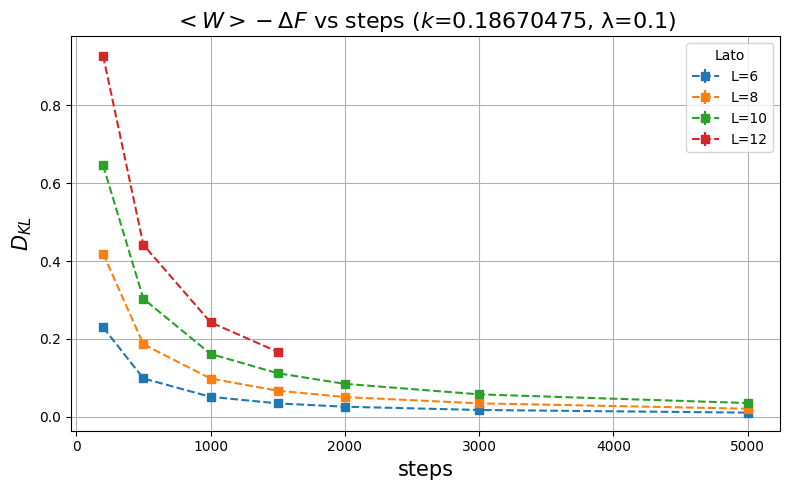

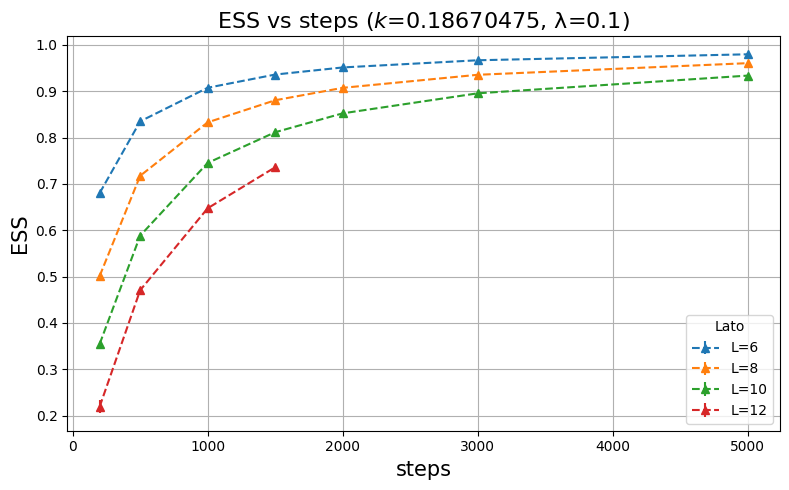

In [148]:
plot_vs_stepsV3(0.18670475, 0.1)

In [26]:
plot_vs_steps(0.188, 0.1)

Nessun dato trovato per kappa=0.188, lambda=0.1


In [58]:
500 * 48**2*24 / 12**3

16000.0

/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_81755/3945067816.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


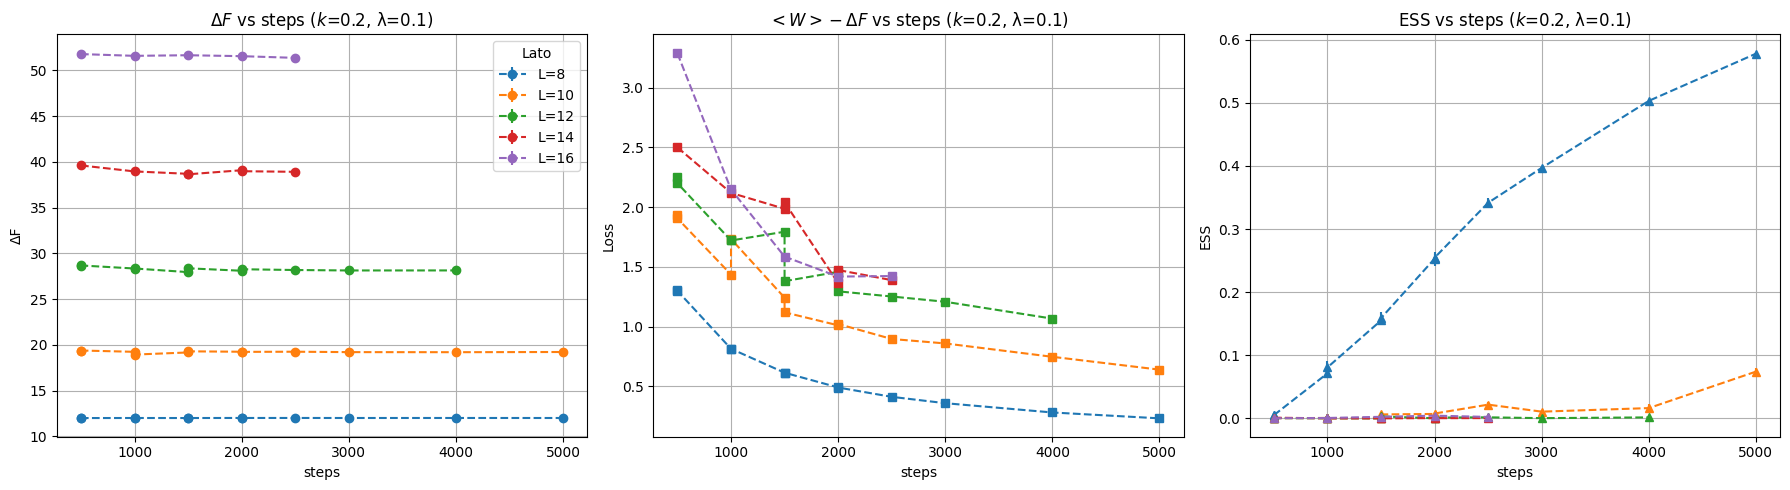

In [19]:
plot_vs_stepsV2(0.2,0.1)

At which kappa can I work?
steps: 190000 tot. max => 150000 steps
ESS_min: 0.05

try:
k: 0.189 and find sigma

/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_81755/1328849130.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


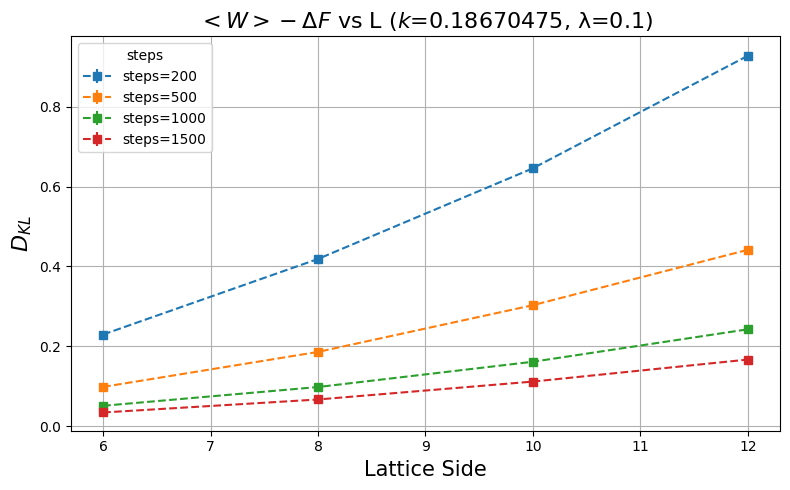

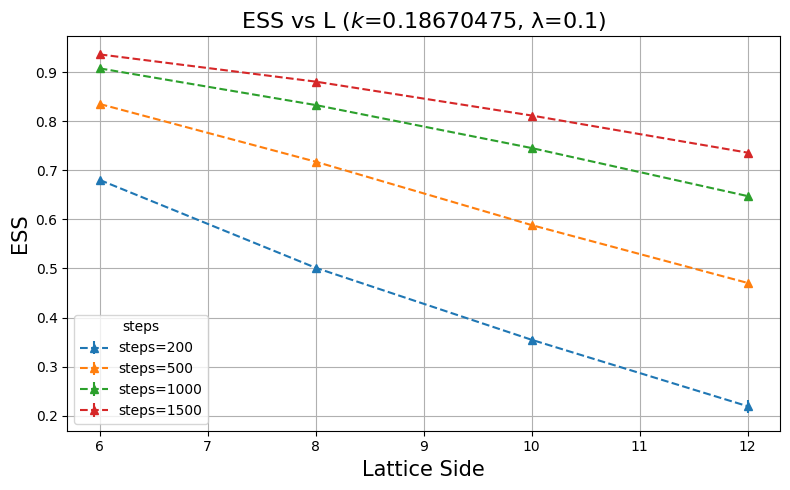

In [151]:
plot_vs_volumeV3(0.18670475, 0.1)

In [152]:
def plot_ess_and_dkl_vs_ratioV2(kappa_target, lambda_target, use_logx=False):
    """
    Crea due plot distinti:
      1) ESS vs (steps / volume)
      2) Dkl = loss - DF vs (steps / volume)
    Raggruppa i punti per valore di L (ogni volume ha un colore/marker).
    """
    # controlli preliminari
    if 'curve_data' not in globals():
        raise RuntimeError("Variabile 'curve_data' non trovata. Esegui prima il caricamento dei dati.")
    if 'frac_to_str' not in globals():
        raise RuntimeError("Funzione 'frac_to_str' non trovata. Definiscila (come nelle celle precedenti).")
    
    kappa_str = frac_to_str(kappa_target)
    lambda_str = frac_to_str(lambda_target)
    
    # filtro i dati per kappa/lambda richiesti
    subset = [e for e in curve_data 
              if frac_to_str(e["kappa"]) == kappa_str and frac_to_str(e["lambda"]) == lambda_str]
    if not subset:
        print(f"Nessun dato trovato per kappa={kappa_target}, λ={lambda_target}")
        return
    
    # raggruppo per L (volumi diversi)
    L_vals = sorted(set(int(e["L"]) for e in subset))
    cmap = plt.cm.get_cmap('tab10')
    markers = ['o','s','D','^','v','P','*','X','h','+']
    
    # --- PLOT ESS ---
    plt.figure(figsize=(8,6))
    for i, L in enumerate(L_vals):
        entries = [e for e in subset if int(e["L"]) == L]
        if len(entries) < 2:
            continue  # serve almeno qualche punto per la curva
        xs = np.array([e["steps"] / (e["L"]**3) for e in entries], dtype=float)
        ys = np.array([e["ESS"] for e in entries], dtype=float)
        yerrs = np.array([e["ESS_err"] for e in entries], dtype=float)
        
        order = np.argsort(xs)
        xs, ys, yerrs = xs[order], ys[order], yerrs[order]
        
        plt.errorbar(xs, ys, yerr=yerrs,
                     marker=markers[i % len(markers)],
                     linestyle='--', capsize=4,
                     color=cmap(i % 10),
                     label=f"L={L}")
    plt.xlabel("steps / volume  (volume = L^3)", fontsize = 15)
    plt.ylabel("ESS", fontsize = 15)
    #plt.title(f"ESS vs steps/volume  ($k$={kappa_target}, λ={lambda_target})")
    if use_logx:
        plt.xscale('log')
    plt.grid(True)
    plt.legend(title="Volume", loc='best')
    plt.tight_layout()
    plt.show()
    
    # --- PLOT Dkl = loss - DF ---
    plt.figure(figsize=(8,6))
    for i, L in enumerate(L_vals):
        entries = [e for e in subset if int(e["L"]) == L]
        if len(entries) < 2:
            continue
        xs = np.array([e["steps"] / (e["L"]**3) for e in entries], dtype=float)
        dkl = np.array([e["loss"] - e["DF"] for e in entries], dtype=float)
        dkl_err = np.array([np.sqrt(e["loss_err"]**2 + e["DF_err"]**2) for e in entries], dtype=float)
        
        order = np.argsort(xs)
        xs, dkl, dkl_err = xs[order], dkl[order], dkl_err[order]
        
        plt.errorbar(xs, dkl, yerr=dkl_err,
                     marker=markers[i % len(markers)],
                     linestyle='--', capsize=4,
                     color=cmap(i % 10),
                     label=f"L={L}")
    plt.xlabel("steps / volume (volume = L^3)", fontsize = 15)
    plt.ylabel("Dkl = <W> - ΔF", fontsize = 15)
    #plt.title(f"Dkl vs steps/volume  ($k$={kappa_target}, λ={lambda_target})")
    if use_logx:
        plt.xscale('log')
    plt.grid(True)
    plt.legend(title="Volume", loc='best')
    plt.tight_layout()
    plt.show()


/var/folders/j5/h2949_ys0s1blqt032r700th0000gn/T/ipykernel_81755/964119157.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


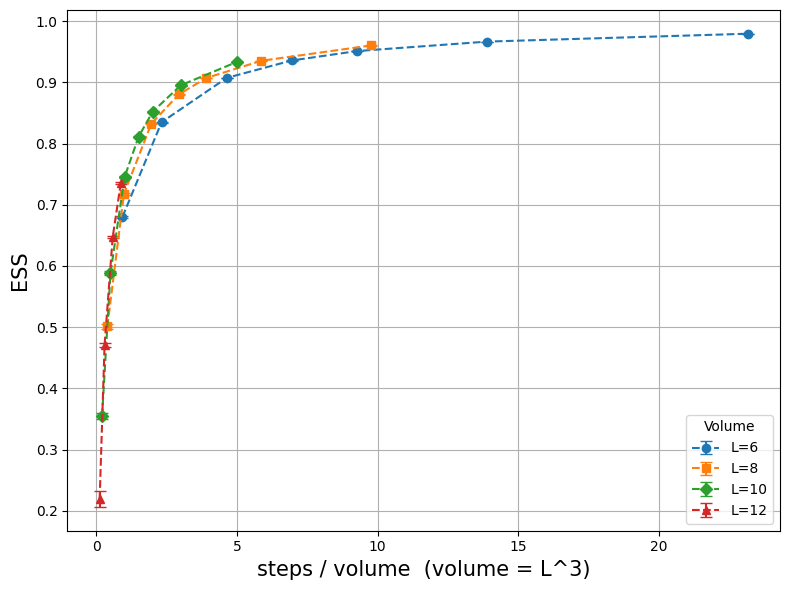

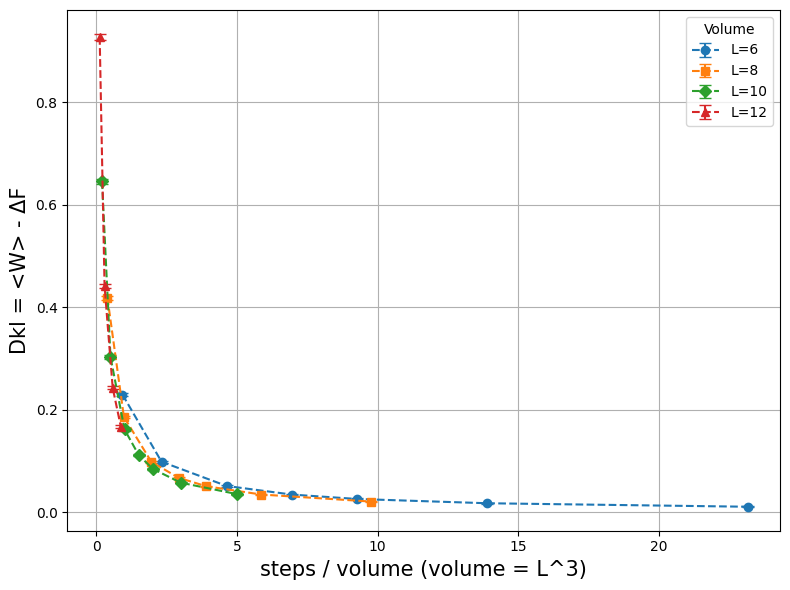

In [154]:
plot_ess_and_dkl_vs_ratioV2(0.18670475,0.1)

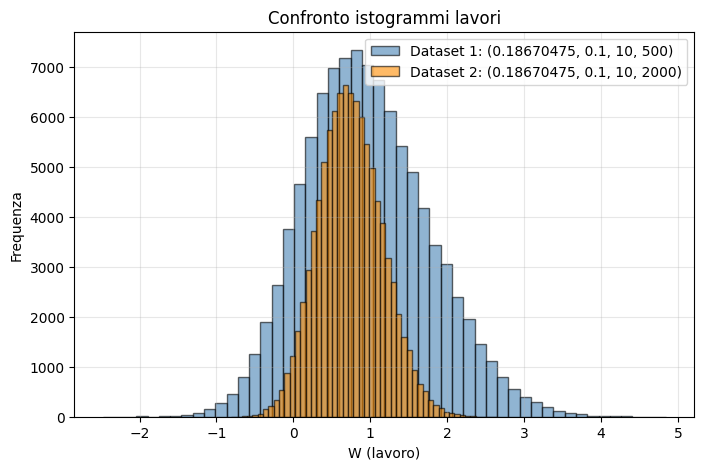

In [64]:
compare_work_histogramsV2((0.18670475, 0.1,10,500),(0.18670475,0.1,10,2000))

In [80]:
def compare_work_histogramsV3(data1, data2, bins=50, density=False):
    """
    Confronta due distribuzioni di lavori W sullo stesso istogramma, 
    usando gli stessi bin per entrambi.
    
    data1, data2 = tuple (kappa, lambda, L, steps)
    bins        = numero di bins o array dei bordi
    density     = se True normalizza le distribuzioni
    """
    
    # Carica i due gruppi di dati
    W1 = load_W(*data1)
    W2 = load_W(*data2)
    
    # Determina il range comune
    wmin = min(np.min(W1), np.min(W2))
    wmax = max(np.max(W1), np.max(W2))
    
    # Calcola i bordi dei bin comuni
    bin_edges = np.linspace(wmin, wmax, bins + 1)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.hist(W1, bins=bin_edges, alpha=0.6, color="steelblue", edgecolor="black",
             label=f"Dataset 1: {data1}", density=density)
    plt.hist(W2, bins=bin_edges, alpha=0.6, color="darkorange", edgecolor="black",
             label=f"Dataset 2: {data2}", density=density)
    
    plt.xlabel("W")
    plt.ylabel("Normalised number of measurements" if not density else "Densità")
    #plt.title("Confronto istogrammi lavori (bin comuni)")
    #plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [136]:
def compare_work_histogramsV4(data1, data2, bins=50):
    """
    Confronta due distribuzioni di lavori W sullo stesso istogramma,
    usando bin comuni e normalizzando in modo che la somma delle altezze
    sia 1 (∑h_i = 1). Aggiunge una linea verticale con incertezza.
    """
    
    # Carica i due insiemi di dati
    W1 = load_W(*data1)
    W2 = load_W(*data2)
    
    # Range comune
    wmin = min(np.min(W1), np.min(W2))
    wmax = max(np.max(W1), np.max(W2))
    
    # Bordi dei bin comuni
    bin_edges = np.linspace(wmin, wmax, bins + 1)
    
    # Calcolo gli istogrammi
    hist1, _ = np.histogram(W1, bins=bin_edges)
    hist2, _ = np.histogram(W2, bins=bin_edges)
    
    # Normalizzazione (somma = 1)
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Centri dei bin
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(bin_centers, hist1, width=np.diff(bin_edges), alpha=0.6, 
            color="steelblue", edgecolor="black", label="$n_{steps}: 200$")
    plt.bar(bin_centers, hist2, width=np.diff(bin_edges), alpha=0.6, 
            color="darkorange", edgecolor="black", label="$n_{steps}: 3000$")
    
    # --- Linea verticale con errore ---
    #mean_val = 1.086508108578275 #k = 0.189
    mean_val = 0.6832963161372195 #k = 0.18670475
    #err_val  = 0.000790120215922197 #k = 0.189
    err_val = 0.00043134257417059137 #k = 0.18670475
    
    ymax = max(hist1.max(), hist2.max())

    # Linea centrale
    plt.axvline(mean_val, color="black", linestyle="--", linewidth=1.5)
    # Linee laterali di errore
    plt.vlines([mean_val - err_val, mean_val + err_val],
               ymin=0, ymax=ymax * 0.9,
               color="black", linestyle=":", linewidth=1)

    # Etichetta sotto la linea centrale
    #plt.text(mean_val, -ymax * 0.07, r"$\Delta F$", 
    #         ha="center", va="top", fontsize=12, color="black")
    
    # Etichetta e aspetto
    plt.xlabel("W")
    plt.ylabel("Normalised number of measurements")
    #plt.title("Confronto istogrammi lavori (bin comuni, somma=1)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


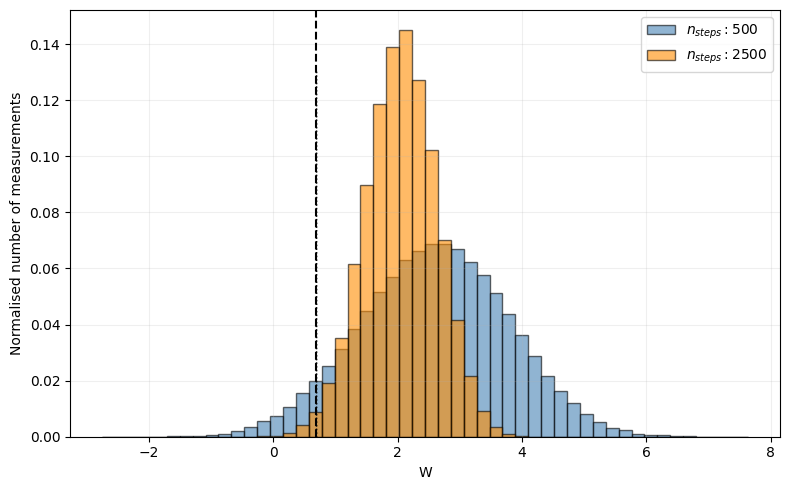

In [134]:
compare_work_histogramsV4((0.189, 0.1,10,500),(0.189,0.1,10,2500))

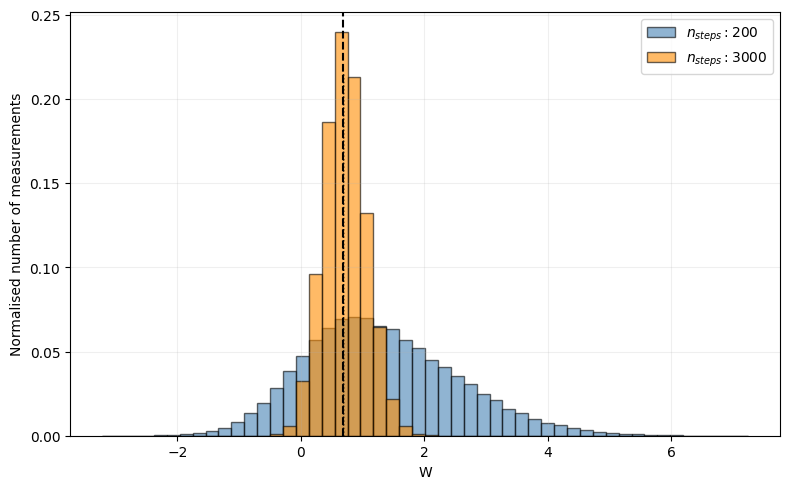

In [137]:
#0.6832963161372195 0.00043134257417059137
compare_work_histogramsV4((0.18670475, 0.1,10,200),(0.18670475,0.1,10,3000))

In [51]:
20*3600/0.5 * 32/24 # L2 fino a 24

192000.0

In [66]:
k = 0.15
str(k).split(".")[-1]

'15'